# Haunted Places in USA

This notebook uses OpenAI's GPT-4 for 
- inferring the taxonomy of classes from textual dataset, and 
- classifying the records in the dataset by this taxonomy.

The resulting taxonomy and classified data entries are then used to produce a categorised map of haunted places in USA in QGIS. The map was made for Day 1 - Points of #30DayMapChallenge 2023.

The source dataset (haunted_places.csv) is the geocoded collection of the haunted places in USA pulled from the Shadowlands Haunted Places Index, scraped, cleaned and geocoded by Tim Renner (https://data.world/timothyrenner).

Dataset: https://data.world/timothyrenner/haunted-places

The dataset has 10 columns, including 
- 'description': descrition of the haunting  and 
- 'location': descriptive name of the location . 

Due to limitations in working with GPT-4 API, this notebook deals only with names of locations.

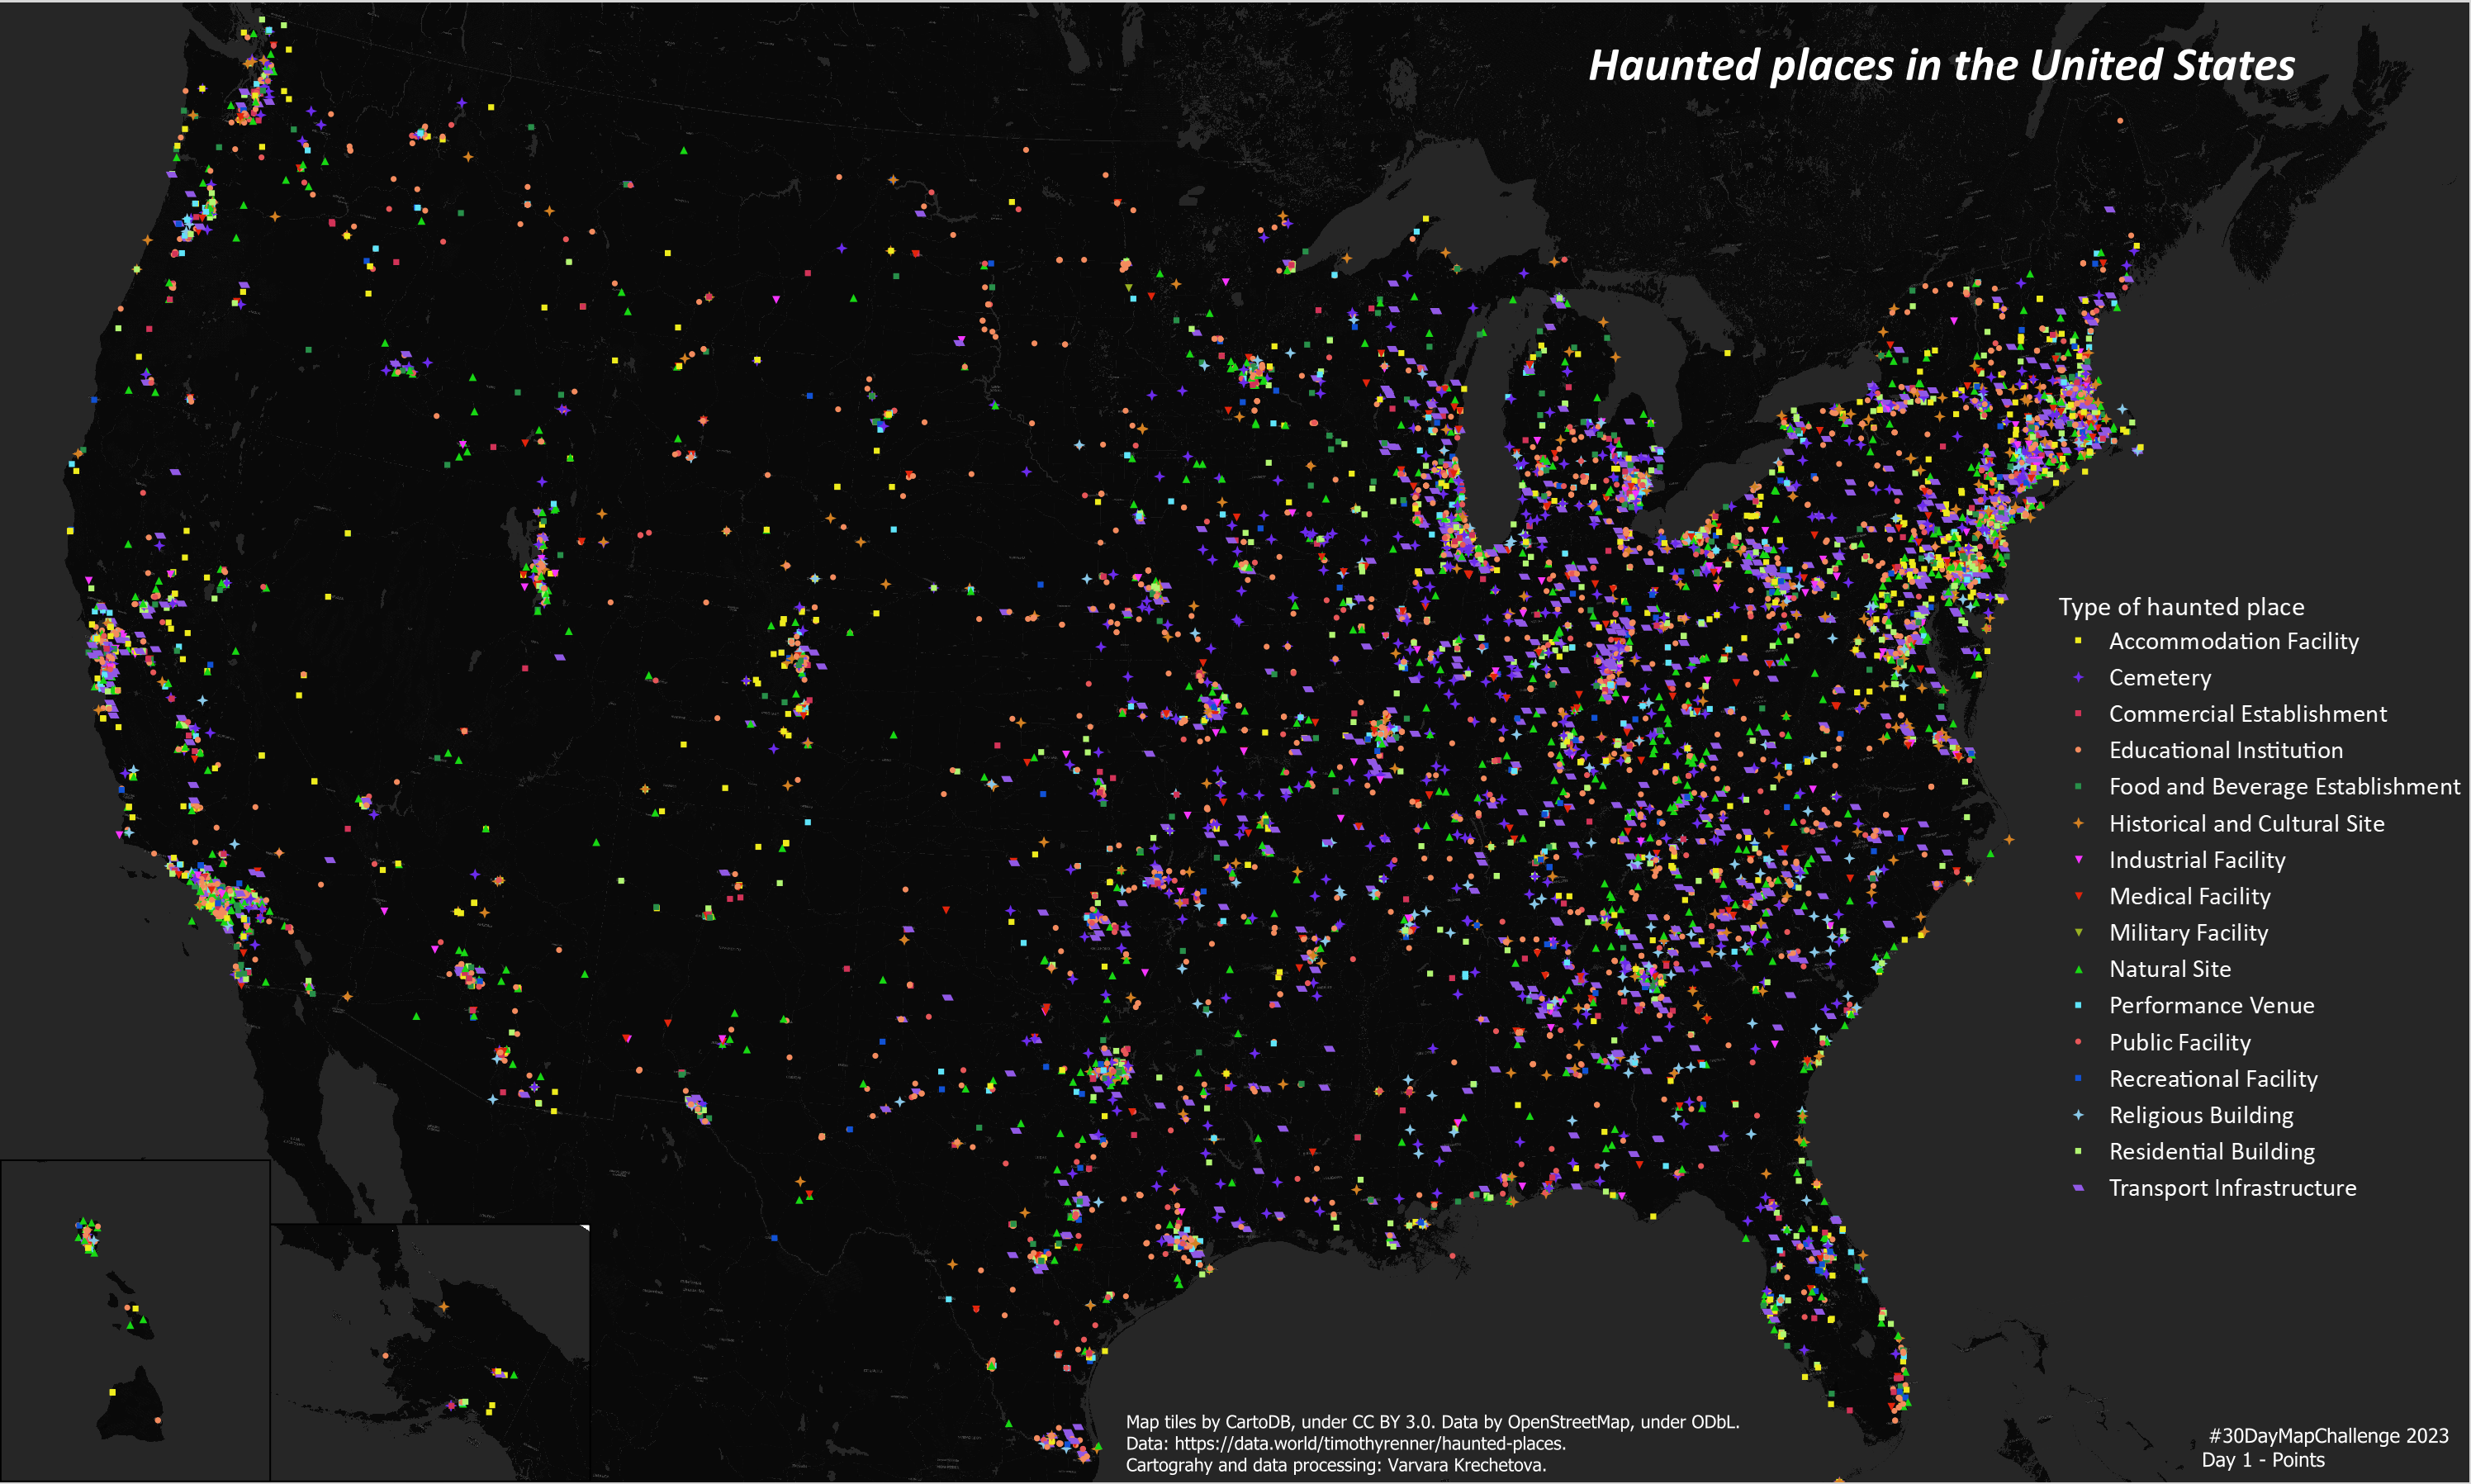

In [1]:
import os
import time
import openai
import pandas as pd
import ast
import pickle
import re
import html

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai.api_key  = os.getenv('OPENAI_API_KEY')

UNKNOWN = 'Unknown'

In [2]:
# To set run mode change the values manually
do_taxonomy = False
save_classification = True

In [3]:
def get_completion(prompt, model="gpt-4"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

## Data load and preprocessing 

In [4]:
source_file = r'.\haunted_places.csv'

hauntedDF = pd.read_csv(source_file, encoding ='utf-8')

# Cleaning column 'location'in the dataframe from empty cells and 
#cells with descriptions instead of place names
clause1 = pd.notna(hauntedDF['location'])
clause2 = hauntedDF['location'].str.len() <= 70
hauntedDF = hauntedDF[clause1&clause2]

# Converting the html escaped symbols to normal characters
hauntedDF.loc[:,'location'] = hauntedDF['location'].apply(html.unescape)

# Converting non-breakable spaces and soft dashes to white spaces
hauntedDF = hauntedDF.replace({'\\xa0': ' ', '\\xad': ''}, regex=True)

hauntedDF.info()
len(hauntedDF)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10961 entries, 0 to 10991
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            10959 non-null  object 
 1   country         10961 non-null  object 
 2   description     10961 non-null  object 
 3   location        10961 non-null  object 
 4   state           10961 non-null  object 
 5   state_abbrev    10961 non-null  object 
 6   longitude       9720 non-null   float64
 7   latitude        9720 non-null   float64
 8   city_longitude  10934 non-null  float64
 9   city_latitude   10934 non-null  float64
dtypes: float64(4), object(6)
memory usage: 942.0+ KB


10961

In [165]:
# Make a list from the column with names/descritions of sightings' locations
places_desc = hauntedDF['location'].tolist()

# Check the result
print("Number of items in 'places_desc':")
print(len(places_desc))
print(places_desc[0:6])

Number of items in 'places_desc':
10961
['Ada Cemetery', 'North Adams Rd.', 'Ghost Trestle', 'Siena Heights University', 'Albion College', 'Riverside Cemetery']


In [ ]:
# Due to context size limitations in the gpt-4 model (8,192 tokens tokens ~ words) take a subset from the list.
# Split the list of places descriptions called "subsets" to use while inferring taxonomy
subsets = [places_desc[i:i+1000] for i in range(0, 11000, 1000)] # for i in range from 0 to 11000 with step 1000

In [166]:
# Smaller subsets are needed at the classification step
subsets_sm = [places_desc[i:i+100] for i in range(0, 11000, 100)] # for i in range from 0 to 11000 with step 1000

## Inferring taxonomy

In [ ]:
if do_taxonomy:
    prompt = f""" 
    Below is the list of haunted places: 
    ```{subsets[0]}```

    Please suggest taxonomy for these places.
    I need only list of unique clasess.
    Maximum number of classes in the taxonomy is 15.

    Indentify classes by usage and purpose of the places. 
    Join classes that are similar by usage.
    Example: elementary school, middle school and High school, Universities are all one class "school". 
    Another example: Hostels, Guest Houses, Aparthotels, Motels, Love Hotels all belong to class "hotel".
    Another example: Woods, Swamps, Hills, Trails all belong to class "natural site"
    Another example: Town Halls, City Halls, Libraries, Community Centers all belong to "public place".

    Please list classes with descrition.
    """

    taxonomy = get_completion(prompt, model = "gpt-4")

In [ ]:
if do_taxonomy:
    for i in range (1,len(subsets)+1):
        prompt_2 = f"""
        Below is the list of haunted places: 
        ```{subsets[i]}```
        This is the taxonomy of haunted places 
        ```{taxonomy}``` .

        Please check that every haunted place in the above list can be fits one of the classes.
        And if needed update the classes names and descriptions so every haunted places\
        in the above list fit one of the classes.
        I need only list of unique clasess.
        Maximum number of classes in the taxonomy is 15.

        Indentify classes by usage and purpose of the places. 
        Join classes that are similar by usage.
        Make sure that cementries and other burial sites are a separate class.
        Example: elementary school, middle school and High school, Universities are all one class "school". 
        Another example: Hostels, Guest Houses, Aparthotels, Motels, Love Hotels all belong to class "hotel".
        Another example: Woods, Swamps, Hills, Trails all belong to class "natural site"
        Another example: Town Halls, City Halls, Libraries, Community Centers all belong to "public place".

        Please list classes of new taxonomy with descrition.
        """
        taxonomy = get_completion(prompt_2, model = "gpt-4")
        time.sleep(10), # To avoid rate limit errors wait 10 seconds before the next step

In [ ]:
if do_taxonomy:
    # Print the last iteration of taxonomy updates
    print(taxonomy)

In [ ]:
# save the taxonomy to the txt file
# open file, w+ argument will create a new text file
if do_taxonomy:
    with open('taxonomy.txt', 'w+') as f:
        f.write(taxonomy)  

In [7]:
# This is the final inferred taxonomy copied from the above cell so that there is no need to run 
# taxonomy inferrence every time 

taxonomy = """
1. "Cemetery": This class includes all types of cemeteries, graveyards, and burial grounds.
2. "Educational Institution": This class includes all types of educational institutions such as elementary schools, middle schools, high schools, colleges, and universities.
3. "Medical Facility": This class includes all types of medical facilities such as hospitals, nursing homes, and sanitariums.
4. "Accommodation Facility": This class includes all types of accommodation facilities such as hotels, motels, inns, lodges, and guest houses.
5. "Natural Site": This class includes all types of natural landscapes such as woods, swamps, hills, trails, parks, and islands.
6. "Public Facility": This class includes all types of public facilities such as town halls, city halls, libraries, community centers, and stadiums.
7. "Food and Beverage Establishment": This class includes all types of food and beverage establishments such as restaurants, cafes, bars, and pubs.
8. "Performance Venue": This class includes all types of performance venues such as theaters, cinemas, auditoriums, and music clubs.
9. "Religious Building": This class includes all types of religious buildings such as churches, temples, chapels, and monasteries.
10. "Historical and Cultural Site": This class includes all types of museums, historical sites, cultural centers, and heritage buildings.
11. "Transport Infrastructure": This class includes all types of transport infrastructures such as bridges, roads, highways, and tunnels.
12. "Residential Building": This class includes all types of residential buildings such as apartments, houses, condos, and mansions.
13. "Commercial Establishment": This class includes all types of commercial establishments such as malls, markets, shops, and department stores.
14. "Industrial Facility": This class includes all types of industrial facilities such as factories, plants, warehouses, and power plants.
15. "Recreational Facility": This class includes all types of recreational facilities such as parks, playgrounds, golf courses, and bowling alleys.
"""

## Classifying records in the dataset

In [168]:
def get_class (i, taxonomy, subsets_sm):
    """ Function to classify data records in subset_sm[i] using taxonomy """
    
    # Converting subset_sm[i] to a string without square brackets and extra commas
    # to avoid the model trying to develop a python script instead of classifying the places.
    # Excaping quotes so the quotes within "location":"class" pairs were distinguishable from outside quotes
    subset_str = "\n".join(s.replace("'", "\\'").replace('"', '\\"') for s in subsets_sm[i])  

    prompt_4 = f"""
    Take the taxonomy from here: 
    ```{taxonomy}```

    Take the list of haunted places from here: 
    ```{subset_str}```

    For each place find appropriate class. 
    Do not skip any place for any reason.
    If place is impossible to classify, classify it as "Unknown"
    List the names of places and matching names of classes.
    Return the result as a list pairs: 
        [("name of place 1", "class of place 1"),
        ("name of place 2", "class of place 2"), 
        etc.].
    Please return only this list of pairs, no text or symbols before or after it. 
    If a name of a place is repeated in the list of haunted places multiple times, 
    please, generate the corresponding pair the same number of times.
    In the end, the pairs in the list should have one-to-one correspondence with the list of haunted places.
    Do not return any snippets of python code.
    """
    response = get_completion(prompt_4, model = "gpt-4")
    return response

In [ ]:
# Running get_class() on the subsets_sm of the 'location' column.
# Storing responses as a list of strings

places_classes = []

for i in range(len(subsets_sm)):
    try:
        print(i, round(time.time()))
        response = get_class(i, taxonomy, subsets_sm)
        places_classes.append(response)
        print(response)
        print("--------------------------------------------------------------------------------------")
    
    except Exception as e:
        places_classes.append(None)
        print("Step failed: ", e)        

In [15]:
# Saving the output of the classification loop (places_classes) for further work 

if save_classification:
    
    with open('places_classes_dumped.pkl', 'wb+') as f: 

        f.write(pickle.dumps(places_classes))

In [23]:
# Unpacking the object for processing

with open('places_classes_dumped.pkl', 'rb') as f:
    backup = f.read()
    places_classes_backup=pickle.loads(backup)

### Just in case part: Filling the gaps where GPT model did not generate proper response

In [26]:
pattern = re.compile(r"\[\s*\(.*?\)\s*\]", re.DOTALL)

for i in range(len(places_classes_backup)):
    
    response = places_classes_backup[i]
    
    if response is not None:
        clean_list = pattern.findall(response)
    else:
        clean_list = []
    
    if len(clean_list) != 1:
        print(i)
        print('trying to call GPT-4 again for batch '+ str(i))
        response = get_class(i, taxonomy, subsets_sm)
        clean_list = pattern.findall(response)
        if len(clean_list) != 1:
            print("Failed at iteration "+str(i))
            print(response)
            break
    
    places_classes_backup[i] = clean_list[0]

58
trying to call GPT-4 again for batch 58
85
trying to call GPT-4 again for batch 85


## Inserting column with classes into the initial hauntedDF dataframe

In [86]:
# Converting the list of responses strings into the combined list of tuples ('location':'class')
final_classification = []

for item in places_classes_backup:
    classified_list = ast.literal_eval(item)
    final_classification.extend(classified_list) 

In [110]:
# Finding match in dictionary 'location':'class' to fill in the "location_type" column
location_type_column = hauntedDF['location'].map(dict(final_classification))

# Inserting new "location_type" column into the dataframe after 'location' column and filling it with 'class' values
hauntedDF.insert(loc = hauntedDF.columns.get_loc('location') + 1, column = 'location_type', value = location_type_column)

In [111]:
hauntedDF.head()

,city,country,description,location,location_type,state,state_abbrev,longitude,latitude,city_longitude,city_latitude
0,Ada,United States,Ada witch - Sometimes you can see a misty blue...,Ada Cemetery,Cemetery,Michigan,MI,-85.504893,42.962106,-85.495480,42.960727
1,Addison,United States,A little girl was killed suddenly while waitin...,North Adams Rd.,Transport Infrastructure,Michigan,MI,-84.381843,41.971425,-84.347168,41.986434
2,Adrian,United States,If you take Gorman Rd. west towards Sand Creek...,Ghost Trestle,Transport Infrastructure,Michigan,MI,-84.035656,41.904538,-84.037166,41.897547
3,Adrian,United States,"In the 1970's, one room, room 211, in the old ...",Siena Heights University,Educational Institution,Michigan,MI,-84.017565,41.905712,-84.037166,41.897547
4,Albion,United States,Kappa Delta Sorority - The Kappa Delta Sororit...,Albion College,Educational Institution,Michigan,MI,-84.745177,42.244006,-84.753030,42.243097


In [163]:
# Saving final output to csv file that can be taken for mapping
hauntedDF.to_csv('haunted_places_classified.csv', index=False)

## Analysis of the output

In [170]:
final_file = r'.\haunted_places_classified.csv'

finalHauntedDF = pd.read_csv(final_file, encoding ='utf-8')

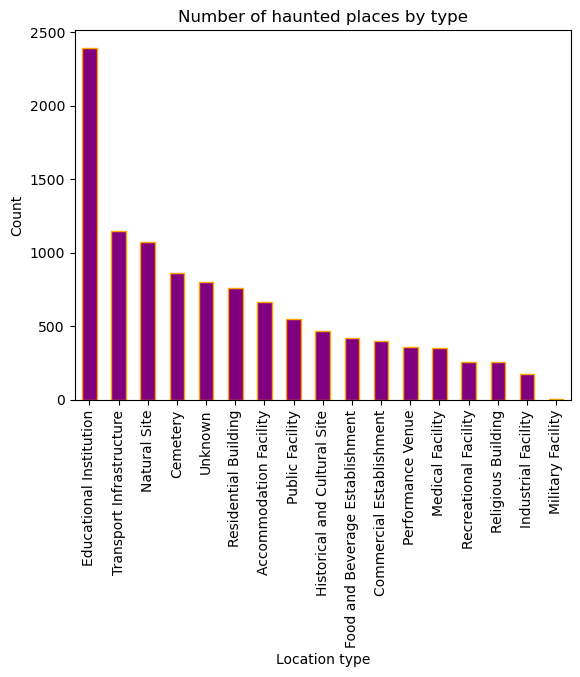

In [176]:
import matplotlib.pyplot as plt

# Count the frequency of each class
location_class_counts = finalHauntedDF['location_type'].value_counts()

# Plot the bar chart
location_class_counts.plot(kind = 'bar', color = 'purple', edgecolor='orange')
plt.title('Number of haunted places by type')
plt.ylabel('Count')
plt.xlabel('Location type')
plt.show()

In [71]:
ind = hauntedDF['location_type'] == UNKNOWN
hauntedDF[ind]

,city,country,description,location,location_type,state,state_abbrev,longitude,latitude,city_longitude,city_latitude
62,Cheboygan,United States,January 2007 has been removed,Pellston,Unknown,Michigan,MI,-84.783936,45.552789,-84.474480,45.646956
113,Detroit,United States,magic stick - The Majestic is a theater on Woo...,Majestic,Unknown,Michigan,MI,-83.204754,42.345937,-83.045754,42.331427
118,Detroit,United States,originally the home of David Whitney now a ver...,The Whitney,Unknown,Michigan,MI,-83.062176,42.352811,-83.045754,42.331427
137,Eau Claire,United States,Frost Cemetery/Munchkin land - There is an ol...,Dowagiac,Unknown,Michigan,MI,-86.222800,41.994500,-86.299739,41.985045
150,Flint,United States,the old Cornwall family is said to still walk ...,Cornwall building,Unknown,Michigan,MI,-83.693569,43.012403,-83.687456,43.012527
...,...,...,...,...,...,...,...,...,...,...,...
10915,Fort Carson,United States,on the third floor a soldier went crazy and ki...,bldg #1047,Unknown,Colorado,CO,-84.511220,39.083889,-104.792088,38.742132
10919,Fort Collins,United States,It's an abandoned goat farm. Many sightings ha...,Hell,Unknown,Colorado,CO,-105.407298,40.330274,-105.084423,40.585260
10937,Hamilton,United States,"The little town of Hamilton near Craig, in Nor...",The Town,Unknown,Colorado,CO,-107.613122,40.367196,-107.613122,40.367196
10960,Manitou Springs,United States,"At the shop downtown, called Mushroom Monday, ...",Mushroom Monday,Unknown,Colorado,CO,-104.918777,38.858848,-104.917199,38.859713
